# Flappy Bird Junco Sim
2D flight sim for EECE5500 Mobile Robotics

In [63]:
############################### Import libraries ###############################
import os
import glob
import time
from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np
from numpy import matlib
import scipy as sci

import gym
import control

In [107]:
class Drone():
    dt = 0.01
    m = 3.2
    Iyy = 1/12*m*0.8**2

    S = 0.25
    c = 0.13

    Cl_0 = 0.5
    Cl_alpha = 0.1*180/np.pi

    Cd_0 = 0.1
    K = 0.05

    Cm_0 = 0.5
    Cm_alpha = -0.14*180/np.pi
    Cm_alpha_dot = -0.008*180/np.pi
    Cm_delta_e = 0.2

    g = 9.81

    vNom = 20
    rhoNom = 1.225
    qNom = 0.5*rhoNom*vNom**2

    ANom = np.array([[0, 1], [Cm_alpha*qNom*S/Iyy, Cm_alpha_dot*qNom*S/Iyy]])
    BNom = np.array([[0], [qNom*Cm_delta_e*S]])
    Q =  np.array([[1, 0], [0, 10]])
    R =  np.array([[0.5]])
    Kgain = control.lqr(ANom, BNom, Q, R)[0]
    print(Kgain)

    KFull = np.zeros(4)

    Qestimation = np.eye(4)/100
    Pestimation = Qestimation
    Restimation = np.array([[1, 0], [0, (0.5/180*np.pi)**2]])/1000
    stateEstimate = np.array([0.0,0.0,0.0,0.0])
    def __init__(self):
        self.x_thres = 10000
        self.z_thresHigh = 500
        self.z_thresLow = 0
        self.v_thres = 50
        self.theta_thres = np.pi/6
        self.theta_dot_thres = np.pi
        self.gamma_thres = np.pi/6
        self.delta_e_stale = 0
        self.thrust_stale = 0


        self.limits = np.array([
            self.x_thres,
            self.z_thresHigh,
            self.z_thresLow,
            self.v_thres,
            self.theta_thres,
            self.theta_dot_thres,
            self.gamma_thres
        ])

        self.state = None
        self.prev_action = None
        self.steps_beyond_terminated = None

        self.time = 0.

    def thetaFromElivator(self, T,thetaDes, delta_e):
        alphaNom = -(self.Cm_0+self.Cm_delta_e*delta_e)/self.Cm_alpha
        Clnom = self.Cl_0 + self.Cl_alpha*alphaNom
        Cdnom = self.Cd_0 + self.K*Clnom**2
        return thetaDes- (-Cdnom/Clnom + T/(self.m*self.g)*(1-Cdnom/Clnom*alphaNom))-alphaNom

    def vGammaFromElivator(self, T, delta_e):
        alphaNom = -(self.Cm_0+self.Cm_delta_e*delta_e)/self.Cm_alpha
        Clnom = self.Cl_0 + self.Cl_alpha*alphaNom
        Cdnom = self.Cd_0 + self.K*Clnom**2
        gammaNom = Cdnom/Clnom*(1-T/self.m/self.g*np.sin(alphaNom)) + T*np.cos(alphaNom)/self.m/self.g
        vNom = np.sqrt(2*(-T*np.sin(alphaNom)+self.m*self.g*np.cos(gammaNom))/(self.S*self.rhoNom))
        return vNom, gammaNom

    def solveForElivator(self, T, thetaDes):
        func = lambda x: self.thetaFromElivator(T, thetaDes,x)
        sol = sci.optimize.root_scalar(func, method='secant', x0 = 0, x1 = 1)
        return sol.root
    
    def elivatorFromAlpha(self, alpha):
        return -(self.Cm_alpha*alpha+self.Cm_0)/self.Cm_delta_e 

    # Calculates a "coherent" (steady state stable) command from thrust and gamma command
    # Returns airspeed, theta, thetadot, and flight path angle (gamma)
    def coherentCommand(self, T, gamma):
        airspeed = self.vNom
        theta = 0
        thetaDot = 0
        verticalForces = lambda X: ((self.Cl_0 + self.Cl_alpha*(X[0]- gamma))*1/2*(X[1]**2)*self.rhoNom*self.S - self.m*self.g*np.cos(gamma) + T*np.sin(X[0]-gamma), \
               ((self.Cd_0+self.K*(self.Cl_0 + self.Cl_alpha*(X[0]- gamma))**2)*1/2*(X[1]**2)*self.rhoNom*self.S -T*np.cos(X[0]-gamma)+self.m*self.g*np.sin(gamma)))

        sol = sci.optimize.root(verticalForces, x0 = [theta, airspeed])
        X =sol.x      
        return [sol.x[1], sol.x[0], thetaDot, gamma]

    # Returns a continous time Jacobian for state and control
    def calculateCTSABMatrix(self, stateIn):
        v, theta, theta_dot, gamma = stateIn
        q = 0.5*self.rhoNom*v**2
        alpha = theta-gamma

        #Calculate alphaDot
        Cl = self.Cl_0 + self.Cl_alpha*alpha
        L = q*self.S*Cl
        gamma_dot = (L - self.m*self.g*np.cos(gamma) +self.thrust_stale*np.sin(alpha)) / (self.m*v)
        alpha_dot = theta_dot-gamma_dot

        #Other aero
        Cd = self.Cd_0 + self.K*Cl**2
        Cm = self.Cm_0 + self.Cm_alpha*alpha + self.Cm_alpha_dot*alpha_dot + self.Cm_delta_e*self.delta_e_stale
        D = q*self.S*Cd
        M = q*self.S*Cm

        #derivatives
        v_dot = (-D - self.m*self.g*np.sin(gamma) + self.thrust_stale*np.cos(alpha)) / self.m
        #theta_dot = theta_dot
        theta_ddot = M / self.Iyy
        gamma_dot = (L - self.m*self.g*np.cos(gamma) +self.thrust_stale*np.sin(alpha)) / (self.m*v)

        #Partial derivatives of aeroforces
        pDpv = self.rhoNom*v*self.S*Cd
        pDptheta = 2*self.K*q*self.S*(self.Cl_alpha * self.Cl_0 + self.Cl_alpha**2*alpha)
        pDpthetaDot = 0
        pDpgamma = -2*self.K*q*self.S*(self.Cl_alpha+self.Cl_alpha**2*alpha)
        pMpv = self.rhoNom*v*self.S*Cm
        pMptheta = q*self.S*self.Cm_alpha
        pMpthetaDot = 0
        pMpgamma = -q*self.S*self.Cm_alpha
        pLpv = self.rhoNom*v*self.S*Cl
        pLptheta = q*self.Cl_alpha
        pLpthetaDot = 0
        pLpgamma = -q*self.Cl_alpha

        #out of order entries
        pf4ptheta = (pLptheta + self.thrust_stale*np.cos(alpha))/(self.m*v)
        pf4pgamma = (pLpgamma/self.m +self.g*np.sin(gamma)-self.thrust_stale/self.m*np.cos(alpha))/v

        #Partial derivatives of nonlinear map with respect to tstate
        pf1pv = - 1/self.m*pDpv
        pf1ptheta = (-pDptheta-self.thrust_stale*np.sin(alpha))/self.m
        pf1pthetaDot = 0
        pf1pgamma = (-pDpgamma/self.m - self.g*np.cos(gamma) + self.thrust_stale/self.m*np.sin(alpha))
        pf2pv = 0
        pf2ptheta = 0
        pf2pthetaDot = 1
        pf2pgamma = 0
        pf3pv = pMpv/self.Iyy
        pf3ptheta = pMptheta/self.Iyy
        pf3pthetaDot = 0
        pf3pgamma = pMpgamma/self.Iyy
        pf4pv = pLpv/(self.m*v)
        pf4pthetaDot = 0

        AFull = np.array([[pf1pv, pf1ptheta, pf1pthetaDot, pf1pgamma],[pf2pv, pf2ptheta, pf2pthetaDot, pf2pgamma],
                      [pf3pv, pf3ptheta, pf3pthetaDot, pf3pgamma],[pf4pv, pf4ptheta, pf4pthetaDot, pf4pgamma]])
        BFull = np.array([[0], [0], [q*self.Cm_delta_e*self.S],[0]])
        return AFull, BFull

    def calculateGains(self):
        x, y, v, theta, theta_dot, gamma = self.state
        AFull, BFull =  self.calculateCTSABMatrix(self.state[2:])

        Qcontrol =  np.array([[0.1,0,0,0],[0,1, 0,0], [0,0, 10,0], [0, 0, 0, 20]])
        Rcontrol =  np.array([[1]])
        Ncontrol = np.zeros([4, 1])
        H = np.array([[1,0,0,0],[0,1,0,0]])

        self.KFull = control.lqr(AFull, BFull, Qcontrol, Rcontrol)[0]
    def EKF(self):
        v, theta, theta_dot, gamma = self.stateEstimate
        alpha = theta-gamma
        q = 0.5*self.rhoNom*v**2

        #Calculate alphaDot
        Cl = self.Cl_0 + self.Cl_alpha*alpha
        L = q*self.S*Cl
        gamma_dot = (L - self.m*self.g*np.cos(gamma) +self.thrust_stale*np.sin(alpha)) / (self.m*v)
        alpha_dot = theta_dot-gamma_dot

        #Other aero
        Cd = self.Cd_0 + self.K*Cl**2
        Cm = self.Cm_0 + self.Cm_alpha*alpha + self.Cm_alpha_dot*alpha_dot + self.Cm_delta_e*self.delta_e_stale
        D = q*self.S*Cd
        M = q*self.S*Cm

        #derivatives
        v_dot = (-D - self.m*self.g*np.sin(gamma) + self.thrust_stale*np.cos(alpha)) / self.m
        #theta_dot = theta_dot
        theta_ddot = M / self.Iyy
        gamma_dot = (L - self.m*self.g*np.cos(gamma) +self.thrust_stale*np.sin(alpha)) / (self.m*v)

        AFull, BFull = self.calculateCTSABMatrix([v, theta, theta_dot, gamma])
        F = AFull*self.dt + np.eye(4) 

        #Observability 
        h = np.array([[self.state[2]],[self.state[3]]])
        H = np.array([[1.0,0.0,0.0,0.0],[0.0,1.0,0.0,0.0]])

        #predict
        v += v_dot*self.dt
        theta += theta_dot*self.dt 
        theta_dot += theta_ddot * self.dt
        gamma += gamma_dot*self.dt
        xEst = np.array([[v], [theta], [theta_dot], [gamma]])

        self.Pestimation = (F)@self.Pestimation @ np.transpose(F) + self.Qestimation
        #update
        y = np.array([[v],[theta]]) - np.array([[self.state[2]],[self.state[3]]]) + np.array([np.random.multivariate_normal([0,0], self.Restimation)]).T
        S = H @ self.Pestimation @ H.T + self.Restimation
        K = self.Pestimation @ np.transpose(H) @ sci.linalg.inv(S)
        xEst -= K @ y
        self.Pestimation = (np.eye(4) - K @ H) @ self.Pestimation
        self.stateEstimate = xEst.flatten()
    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        

        #Extra states
        x, z, v, theta, theta_dot, gamma = self.state
        rho = np.random.normal(self.rhoNom,0.0)
        alpha = theta - gamma
        q = 0.5*rho*v**2
        
        #Control inputs
        if (self.time > 0):
            self.EKF()
        thrust, stateCommand = action
        delta_e = self.elivatorFromAlpha(stateCommand[1]-stateCommand[3])
        controlDirect = self.Kgain @ (np.array([[theta], [theta_dot]])-np.array([[stateCommand[1]], [0]]))
        error = (np.array([self.stateEstimate]).T-np.array([stateCommand]).T)
        controlFull = self.KFull @ error
        delta_e = delta_e -controlFull[0][0]

        #alpha dot
        Cl = self.Cl_0 + self.Cl_alpha*alpha
        L = q*self.S*Cl
        gamma_dot = (L - self.m*self.g*np.cos(gamma) +thrust*np.sin(alpha)) / (self.m*v)
        alpha_dot = theta_dot-gamma_dot

        # Forces
        Cd = self.Cd_0 + self.K*Cl**2
        Cm = self.Cm_0 + self.Cm_alpha*alpha + self.Cm_alpha_dot*alpha_dot + self.Cm_delta_e*delta_e
        D = q*self.S*Cd
        M = q*self.S*Cm

        #derivatives
        x_dot = v*np.cos(gamma)
        z_dot = v*np.sin(gamma)
        v_dot = (-D - self.m*self.g*np.sin(gamma) + thrust*np.cos(alpha)) / self.m
        #theta_dot = theta_dot
        theta_ddot = M / self.Iyy
        #Old controls for filter
        self.delta_e_stale = delta_e
        self.thrust_stale = thrust

        # integrate
        x += x_dot*self.dt
        z += z_dot*self.dt
        v += v_dot*self.dt 
        theta += theta_dot*self.dt #Removed second order terms.  We don't do that here (Also needs to be 1/2dt^2 f"(t))
        theta_dot += theta_ddot * self.dt
        gamma += gamma_dot*self.dt

        state = np.array([x,z,v,theta,theta_dot,gamma])
        action = np.array([thrust,delta_e])

        self.state = (list(np.reshape(state,(6,))))
        self.time += self.dt

        terminated = bool(
            x < -self.x_thres
            or x > self.x_thres
            or z > self.z_thresHigh
            or z < self.z_thresLow
            or v < -self.v_thres
            or v > self.v_thres
            or theta < -self.theta_thres
            or theta > self.theta_thres
            or theta_dot < -self.theta_dot_thres
            or theta_dot > self.theta_dot_thres
            or gamma < -self.gamma_thres
            or gamma > self.gamma_thres
        )

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            self.steps_beyond_terminated = 0
            reward = 0.0
        else:
            if self.steps_beyond_terminated == 0:
                print(self.state)
                gym.logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0.0

        return state, reward, terminated, False

    def reset(self):
        self.state = np.array([0.0,100.0,self.vNom,0.0,0.0,0.0])
        self.state[2:] = self.coherentCommand(5,1/180*np.pi)
        self.stateEstimate = self.coherentCommand(5,1/180*np.pi)
        self.Pestimation = self.Qestimation
        self.steps_beyond_terminated = None
        self.time = 0
        self.calculateGains()

        return self.state

    def close(self):
        pass

[[0.00425524 0.72512213]]


reseting gains for controller
(array([[ -0.59763343, -17.76481777,   1.76231715,  29.37651865]]), array([[ 4.44004069e-01,  2.08447205e+00, -1.15965931e-01,
        -9.36229553e+00],
       [ 2.08447205e+00,  3.01108030e+02, -3.44711913e+00,
        -2.81589701e+02],
       [-1.15965931e-01, -3.44711913e+00,  3.41963382e-01,
         5.70027573e+00],
       [-9.36229553e+00, -2.81589701e+02,  5.70027573e+00,
         4.57371966e+02]]), array([-11.32648077+33.25590103j, -11.32648077-33.25590103j,
        -0.42752718 +0.10578578j,  -0.42752718 -0.10578578j]))
[[-2.12735176e-01 -5.51159117e+00  0.00000000e+00 -1.99007657e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-1.11534396e+01 -1.21109003e+03  0.00000000e+00  1.21109003e+03]
 [ 1.14328891e-01  1.42263317e+01  0.00000000e+00 -1.42131336e+01]]
[[0.        ]
 [0.        ]
 [5.15352591]
 [0.        ]]


/tmp/ipykernel_3765/3393988402.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


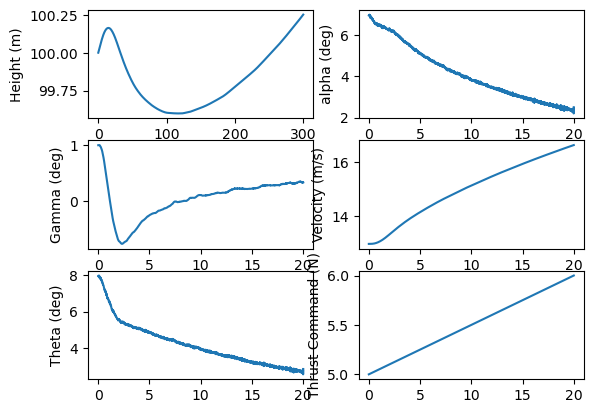

In [114]:
env = Drone()
state = env.reset()
fig, axs = plt.subplots(3, 2)
iterations = 2000
trajx = np.zeros(iterations)
trajz = np.zeros(iterations)
trajv = np.zeros(iterations)
trajtheta = np.zeros(iterations)
trajthetaDot = np.zeros(iterations)
trajgamma = np.zeros(iterations)
trajt = np.zeros(iterations)
thrustCommand = np.zeros(iterations)+5+np.linspace(0,1,iterations)
for iter in range(0, iterations):
    action = [thrustCommand[iter], env.coherentCommand(thrustCommand[iter],1/180*np.pi)] 
    state, reward, done, _ = env.step(action)
    trajt[iter] = env.time
    trajx[iter], trajz[iter], trajv[iter], trajtheta[iter], trajthetaDot[iter], trajgamma[iter]   = state

axs[0, 0].plot(trajx, trajz)
axs[0, 0].set_ylabel("Height (m)")
axs[0, 1].plot(trajt, (trajtheta-trajgamma)*180/np.pi)
axs[0, 1].set_ylabel("alpha (deg)")
axs[1, 0].plot(trajt, trajgamma*180/np.pi)
axs[1, 0].set_ylabel("Gamma (deg)")
axs[1, 1].plot(trajt, trajv)
axs[1, 1].set_ylabel("Velocity (m/s)")
axs[2, 0].plot(trajt, trajtheta*180/np.pi)
axs[2, 0].set_ylabel("Theta (deg)")
axs[2, 1].plot(trajt, thrustCommand)
axs[2, 1].set_ylabel("Thrust Command (N)")
fig.show()

In [37]:
env = Drone()
print(env.coherentCommand(0,-10/180*np.pi))


 message: The solution converged.
 success: True
  status: 1
     fun: [-8.505e-12  1.154e-11]
       x: [ 2.298e-01  8.467e+00]
    nfev: 20
    fjac: [[-9.558e-01 -2.941e-01]
           [ 2.941e-01 -9.558e-01]]
       r: [-6.477e+01 -7.298e+00  7.436e-01]
     qtf: [-1.643e-09  6.255e-09]
[8.466689665215268, 0.22975822601976395, 0, -0.17453292519943295]


In [240]:
#################################### Testing ###################################

env = Drone()
state = env.reset()

%matplotlib qt
fig, ax = plt.subplots(1,figsize=(10,5))
traj = []

for t in range(1, 1500):
    action =  [2, env.coherentCommand(2,1/180*np.pi)] 

    state, reward, done, _ = env.step(action)
    x = state[0]
    z = -state[1]
    v = state[2]
    theta = -state[3]
    theta_dot = -state[4]
    gamma = state[5]
    traj.append((x,z))

        
    #if v<25:
    #    action[0] = 200
    #else:
    #    action[0] = 0
        
    l = 0.8
    plt.plot([x,x+0.25*l*np.cos(theta)],[z,z+0.25*l*np.sin(theta)],'k-')
    plt.plot([x,x-0.75*l*np.cos(theta)],[z,z-0.75*l*np.sin(theta)],'k-')
    plt.xlim(x-20,x+80)
    plt.ylim(z-25,z+25)

    beam = 50
    angle = 60*np.pi/180
    plt.plot([x,x+beam*np.cos(theta+angle/2)],[z,z+beam*np.sin(theta+angle/2)],'k--')
    plt.plot([x,x+beam*np.cos(theta-angle/2)],[z,z+beam*np.sin(theta-angle/2)],'k--')
    xs = x+beam*np.cos(theta+np.linspace(-angle/2,angle/2,10))
    zs = z+beam*np.sin(theta+np.linspace(-angle/2,angle/2,10))
    plt.plot(xs,zs,'k.',markersize=1)

    x,z = zip(*traj)
    plt.plot(x,z,'b-',markersize=1)
    
    plt.show()
    plt.pause(env.dt)

    if done:
        break
    else:
        ax.clear()
print(np.around(state,2), reward, done)
env.close()

reseting gains for controller
[[-5.53142169e-04 -7.08424746e-02 -6.19457743e-06  6.55037155e-02]]
